# 沿海水域关键营养物质的时空分布估算

## 1 项目介绍

###  1.1 背景介绍

**近海DSi精细尺度反演的时空智能方法**

该案例显示了一种时空加权智能方法，可以获得沿海溶解硅酸盐（DSi）的高分辨率和长期分布。在近岸海域观察并揭示了由生物和物理因素驱动的精细尺度DSi变化和影响。

溶解硅酸盐（DSi）从陆地向海岸环境的迁移是全球生物地球化学循环的重要组成部分。由于沿海水域强烈的陆海相互作用，沿海DSi的空间分布呈现出不规则特征（受陆地输入和海洋地形的影响），时间变化迅速，周期性波动短暂（受生物效应和洋流的影响）。然而，由于时空建模的不成熟和数据采样的低分辨率，目前对沿海DSi的研究通常以数百公里的空间和季节时间分辨率描述其粗略变化。因此，该项目将结合先进的时空分析模型和高分辨率数据集，以更高的时空分辨率分析海上DSi分布的变化。

> [Qi, J., Du, Z., Wu, S., Chen, Y., & Wang, Y. (2023). A spatiotemporally weighted intelligent method for exploring fine-scale distributions of surface dissolved silicate in coastal seas. Science of The Total Environment , 886, 163981.  ](https://doi.org/10.1016/j.scitotenv.2023.163981)  

### 1.2 数据说明

2010年至2018年浙江近海地表DSi数据集（通过将MODIS遥感数据集与近海地表溶解硅酸盐现场数据集进行匹配获得）。

### 1.3 分析过程

- 依赖库安装
- 数据集导入
- 模型设置
- 模型训练

### 1.4 研究区域示意图


![Image Name](https://mydde.deep-time.org/s3/static-files/upload/upload/1695121607986_1.jpg)  

## 2 准备工作

依赖库导入

In [1]:
from gnnwr.models import GTNNWR
from gnnwr.datasets import init_dataset
import numpy as np
import pandas as pd

## 3 模型训练

### 3.1 数据导入

In [2]:
data = pd.read_csv('../data/demo_data_gtnnwr.csv')
data.head()

,refl_b01,refl_b02,refl_b03,refl_b04,refl_b05,refl_b07,proj_x,proj_y,day,SiO3
0,1895,1251,1737,1872,543,280,736685.4179,3314205.295,113,1.049
1,1621,1066,1435,1665,757,511,736685.4179,3314205.295,121,1.209
2,1587,1141,1807,1864,1211,1024,736685.4179,3314205.295,152,1.102
3,1121,1012,1411,1324,711,485,768193.4945,3402138.581,168,0.945
4,913,203,840,1035,114,63,736685.4179,3314205.295,200,1.350


通过`init_dataset()`函数，用户可以设置输入数据、测试集大小、验证集大小、自变量、因变量、空间属性、时间属性、编号列、随机种子和批量大小。

初始化的数据集可以使用`save()`方法保存，`read`方法可以用于`read`保存的结果。

In [3]:
data["id"] = np.arange(len(data))
train_dataset, val_dataset, test_dataset = init_dataset(data=data,
                                                        test_ratio=0.15,
                                                        valid_ratio=0.1,
                                                        x_column=['refl_b01', 'refl_b02',
                                                                  'refl_b03', 'refl_b04', 'refl_b05',
                                                                  'refl_b07'],
                                                        y_column=['SiO3'],
                                                        spatial_column=[
                                                            'proj_x', 'proj_y'],
                                                        temp_column=['day'],
                                                        id_column=['id'],
                                                        use_model="gtnnwr",
                                                        sample_seed=48,
                                                        batch_size=1024)

### 3.2 模型设置

该模型接受训练集、验证集、测试集、隐藏层和优化器等参数，并可以设置网络结构、优化器类型和学习率调整方法。

`add_graph()`函数可用于保存模型的图结构，可以在Tensorboard中查看。

In [4]:
optimizer_params = {
    "scheduler": "MultiStepLR",
    "scheduler_milestones": [1000, 2000, 3000, 4000],
    "scheduler_gamma": 0.8,
}
gtnnwr = GTNNWR(train_dataset, val_dataset, test_dataset, [[3], [512, 256, 64]], drop_out=0.4, optimizer='Adadelta', optimizer_params=optimizer_params,
                write_path="../demo_result/gtnnwr/runs/",  # 这里需要修改
                model_save_path="../demo_result/gtnnwr/models/",
                log_path="../demo_result/gtnnwr/logs/",
                model_name="GTNNWR_DSi")
gtnnwr.add_graph()

Add Graph Successfully


### 3.3 模型训练  

使用`run`方法可以进行模型训练，并可以设置训练步长和早停步长。

In [5]:
gtnnwr.run(200, 50)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [01:03<00:00,  3.13it/s, Train Loss=0.654475, Train R2=-0.136637, Train AIC=5359.6753, Valid Loss=0.348, Valid R2=0.346, Best Valid R2=0.346, Learning Rate=0.1]  


### 3.4 模型输出

使用`result()`可以获得最优模型的基本信息以及模型在测试集上的运行结果

使用`reg_result()`可以保存整个数据集上最优模型的运行结果，包括模型计算的时空非平稳权重。

In [6]:
gtnnwr.result()

--------------------Model Information-----------------
Model Name:           | GTNNWR_DSi
independent variable: | ['refl_b01', 'refl_b02', 'refl_b03', 'refl_b04', 'refl_b05', 'refl_b07']
dependent variable:   | ['SiO3']

OLS coefficients: 
x0: 7.70582
x1: 0.80789
x2: 0.35238
x3: -7.27008
x4: 2.71207
x5: -2.70717
Intercept: 1.14341

--------------------Result Information----------------
Test Loss: |                   0.36002
Test R2  : |                   0.34206
Train R2 : |                   0.35378
Valid R2 : |                   0.34643
RMSE: |                        0.60002
AIC:  |                      795.48254
AICc: |                      801.18414
F1:   |                        0.58032
F2:   |                        7.07785
f3_param_0: |                  3.94461
f3_param_1: |                  8.49798
f3_param_2: |                  1.14623
f3_param_3: |                  0.07523
f3_param_4: |                  3.78982
f3_param_5: |                 32.53742
f3_param_6: |             

In [7]:
result_data = gtnnwr.reg_result('../demo_result/gtnnwr/gtnnwr_result.csv')
result_data

,coef_refl_b01,coef_refl_b02,coef_refl_b03,coef_refl_b04,coef_refl_b05,coef_refl_b07,bias,Pred_SiO3,id,dataset_belong,denormalized_pred_result
0,1.940916,-0.283860,-0.067999,-1.394895,-0.979911,0.021196,1.455532,1.564216,2730,train,1.564216
1,-0.410207,0.297343,-0.049788,1.085227,0.500964,-0.057419,0.779118,0.881114,1520,train,0.881114
2,1.098114,-0.190340,-0.081715,-0.339349,-0.555052,-0.419049,1.569469,1.556025,525,train,1.556025
3,3.584155,0.109951,-0.146093,-1.490272,-1.080250,0.002662,0.800459,1.288403,1510,train,1.288403
4,0.470609,-0.074786,-0.110306,0.322804,-0.615852,-0.126700,1.206451,1.219628,697,train,1.219628
...,...,...,...,...,...,...,...,...,...,...,...
2896,4.063159,0.237773,-0.216600,-1.646158,-0.639441,0.460679,0.867058,1.303689,1853,test,1.303689
2897,2.557924,-0.262583,-0.055180,-0.972126,-1.249024,-0.085510,1.251122,1.569227,2844,test,1.569227
2898,1.240896,0.349453,-0.108519,0.078868,5.873232,0.203107,0.933091,1.377350,571,test,1.377350
2899,3.805270,0.215857,-0.180514,-1.730431,-0.689228,0.299099,0.865110,1.172676,1903,test,1.172676


### 3.5 模型结果分析


模型的输出结果可以通过绘制图像和其他方法导入和分析

R2: 0.3518267064128938


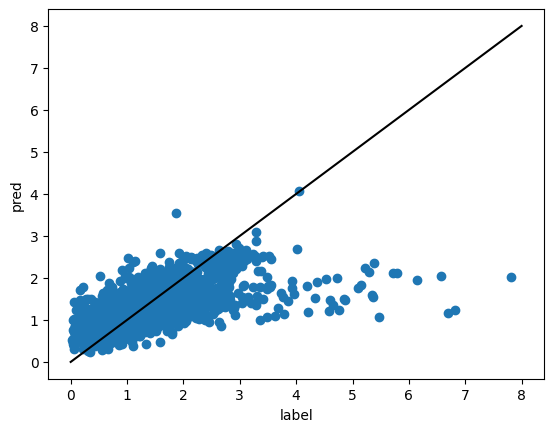

In [8]:
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score as r2
result_data.sort_values(by='id', inplace=True)
data.sort_values(by='id', inplace=True)
print('R2:', r2(data['SiO3'], result_data['Pred_SiO3']))
plt.scatter(data['SiO3'], result_data['Pred_SiO3'])
plt.plot([i for i in range(9)], [i for i in range(9)], color='black')
plt.xlabel('label')
plt.ylabel('pred')
plt.show()

In [9]:
ana_data = pd.merge(data, result_data, on='id')

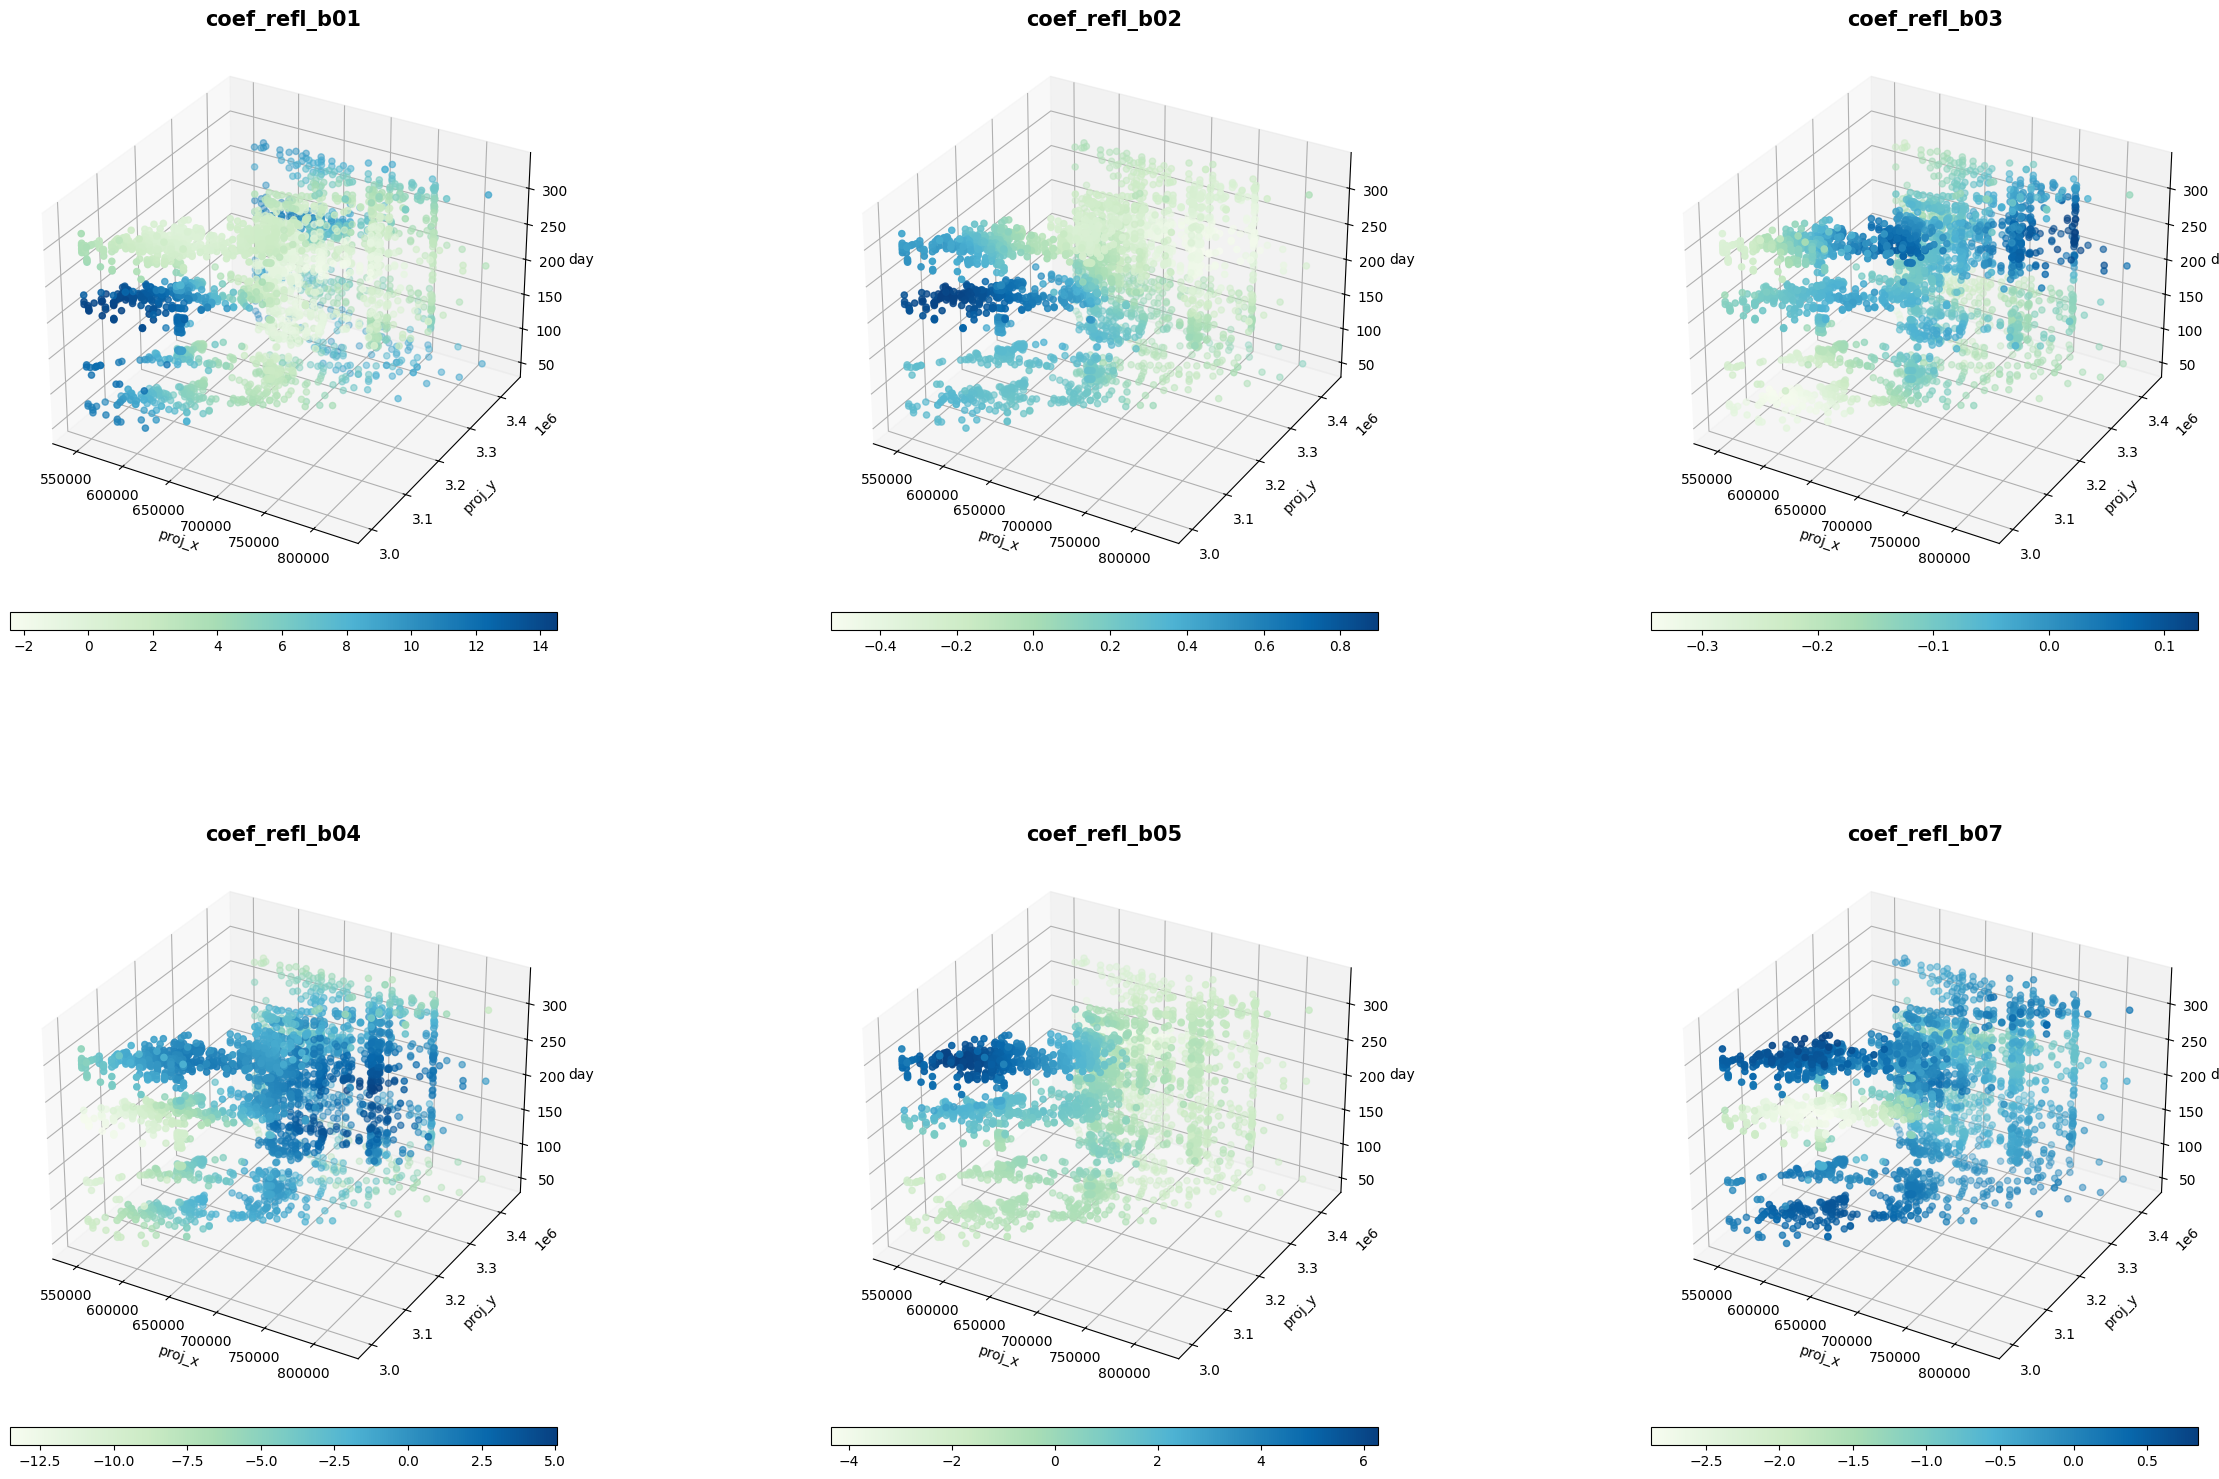

In [10]:
fig = plt.figure(figsize=(30, 30))
plt.rcParams['font.sans-serif'] = ['Arial Unicode MS']
id = 1
for i in [1, 2, 3, 4, 5, 7]:
    ax = fig.add_subplot(3, 3, id, projection='3d')
    fig.colorbar(ax.scatter(ana_data['proj_x'], ana_data['proj_y'], ana_data['day'],
                            c=ana_data['coef_refl_b0'+str(i)], cmap='GnBu'),
                 shrink=0.8, aspect=30, orientation='horizontal', pad=0.05)
    ax.set_xlabel('proj_x')
    ax.set_ylabel('proj_y')
    ax.set_zlabel('day')
    ax.set_title('coef_refl_b0'+str(i), fontsize=15, fontweight='bold')
    id += 1